## I'm trying to understand deep learning and how overparameterized networks dont overfit.

**this is the plan:**
* Generate 100k data points from a complex curve (perhaps a polynomial, but open to other suggestions)
* Build a wide and deep network with a million parameters 
* Initialize with xavier initialization
* Split dataset into train and test
* Plot loss of both train and test over time as network trains
* In the end plot the curve with predictions of test data points from the network to visually ensure they don't overfit

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
def count_parameters(model):
    """Count trainable parameters and show parameter count for each layer"""
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param_count = parameter.numel()
        total_params += param_count
        print(f"{name}: {param_count:,} parameters")
    print(f"\nTotal trainable parameters: {total_params:,}")
    return total_params

In [3]:
# Generate synthetic data
def generate_data(n_samples=100000):
    x = np.linspace(-10, 10, n_samples)
    # Complex function: combination of polynomial and trigonometric terms
    y = 0.1 * x**3 - 0.5 * x**2 + 2 * np.sin(x) + np.cos(0.5 * x) + \
        0.2 * np.sin(2 * x) * np.cos(0.5 * x)
    # Add noise
    y += np.random.normal(0, 0.5, n_samples)
    return x.reshape(-1, 1), y.reshape(-1, 1)

In [19]:
class OverParamNetwork(nn.Module):
    def __init__(self):
        super(OverParamNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
        # Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.network(x)

# Create model and compile it
model = OverParamNetwork()

In [20]:
number_of_params = count_parameters(model)

network.0.weight: 512 parameters
network.0.bias: 512 parameters
network.2.weight: 262,144 parameters
network.2.bias: 512 parameters
network.4.weight: 262,144 parameters
network.4.bias: 512 parameters
network.6.weight: 262,144 parameters
network.6.bias: 512 parameters
network.8.weight: 262,144 parameters
network.8.bias: 512 parameters
network.10.weight: 262,144 parameters
network.10.bias: 512 parameters
network.12.weight: 262,144 parameters
network.12.bias: 512 parameters
network.14.weight: 262,144 parameters
network.14.bias: 512 parameters
network.16.weight: 512 parameters
network.16.bias: 1 parameters

Total trainable parameters: 1,840,129


In [21]:
n_samples = 100000
# print how bigger in parameters model is vs n_samples
print(f"Model has {number_of_params} parameters, which is {number_of_params/n_samples:.2f} times bigger than the number of samples")

Model has 1840129 parameters, which is 18.40 times bigger than the number of samples


In [22]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nVerification using PyTorch's built-in counting: {pytorch_total_params:,} parameters")


Verification using PyTorch's built-in counting: 1,840,129 parameters


In [23]:
model = torch.compile(model, backend="eager")  # Use eager backend instead of default

In [12]:
# Generate and prepare data
X, y = generate_data(n_samples=n_samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create data loaders with larger batch size
BATCH_SIZE = 100  # Using 100 points per batch as requested
train_data = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# This is how the data looks like

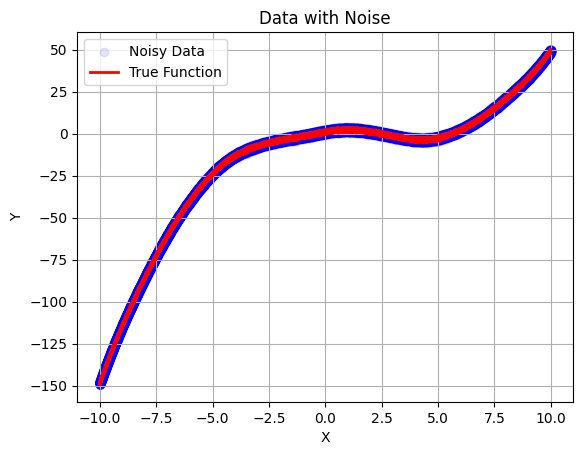

In [33]:
plt.scatter(X, y, c='b', alpha=0.1, label='Noisy Data')
plt.plot(X, y, 'r-', label='True Function', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data with Noise')
plt.legend()
plt.grid(True)
plt.show()

## train for 2 epochs

In [16]:
def train_network(model, train_loader, test_loader, epochs=2, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    n_batches = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(x_batch.float())
            loss = criterion(output, y_batch.float())
            loss.backward()
            optimizer.step()
            
            # Record training loss for this batch
            train_losses.append(loss.item())
            
            # Test loss for this batch
            model.eval()
            with torch.no_grad():
                test_loss = 0
                for x_test, y_test in test_loader:
                    output = model(x_test.float())
                    test_loss += criterion(output, y_test.float()).item() * x_test.size(0)
                test_losses.append(test_loss / len(test_loader.dataset))
            model.train()
            
            n_batches += 1
            if n_batches % 100 == 0:  # Print every 100 batches
                print(f'Batch [{n_batches}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    
    return train_losses, test_losses

In [17]:
def plot_losses(train_losses, test_losses, window_size=50):
    """Plot both raw and smoothed losses"""
    plt.figure(figsize=(12, 6))
    
    # Plot raw losses with low alpha
    plt.plot(train_losses, label='Train Loss (Raw)', alpha=0.2, color='blue')
    plt.plot(test_losses, label='Test Loss (Raw)', alpha=0.2, color='red')
    
    # Calculate and plot smoothed losses
    def smooth(losses, window_size):
        kernel = np.ones(window_size) / window_size
        return np.convolve(losses, kernel, mode='valid')
    
    smoothed_train = smooth(train_losses, window_size)
    smoothed_test = smooth(test_losses, window_size)
    
    plt.plot(np.arange(window_size-1, len(train_losses)), 
             smoothed_train, 
             label='Train Loss (Smoothed)', 
             color='blue', 
             linewidth=2)
    plt.plot(np.arange(window_size-1, len(test_losses)), 
             smoothed_test, 
             label='Test Loss (Smoothed)', 
             color='red', 
             linewidth=2)
    
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
# Train model and plot results
train_losses, test_losses = train_network(model, train_loader, test_loader, epochs=2, lr=1e-4)

Batch [100], Train Loss: 265.2581, Test Loss: 268.4630
Batch [200], Train Loss: 293.2556, Test Loss: 214.7044
Batch [300], Train Loss: 121.1852, Test Loss: 81.9675
Batch [400], Train Loss: 6.3561, Test Loss: 4.8490
Batch [500], Train Loss: 1.3014, Test Loss: 2.5002
Batch [600], Train Loss: 3.7463, Test Loss: 1.7404
Batch [700], Train Loss: 1.1728, Test Loss: 0.5938
Batch [800], Train Loss: 0.9349, Test Loss: 0.8083
Batch [900], Train Loss: 0.8033, Test Loss: 0.4307
Batch [1000], Train Loss: 0.7206, Test Loss: 0.4513
Batch [1100], Train Loss: 1.0470, Test Loss: 0.3521
Batch [1200], Train Loss: 0.2510, Test Loss: 0.3752
Batch [1300], Train Loss: 4.0907, Test Loss: 1.5667
Batch [1400], Train Loss: 0.8351, Test Loss: 0.9293
Batch [1500], Train Loss: 0.3197, Test Loss: 0.4412
Batch [1600], Train Loss: 0.3047, Test Loss: 0.5132


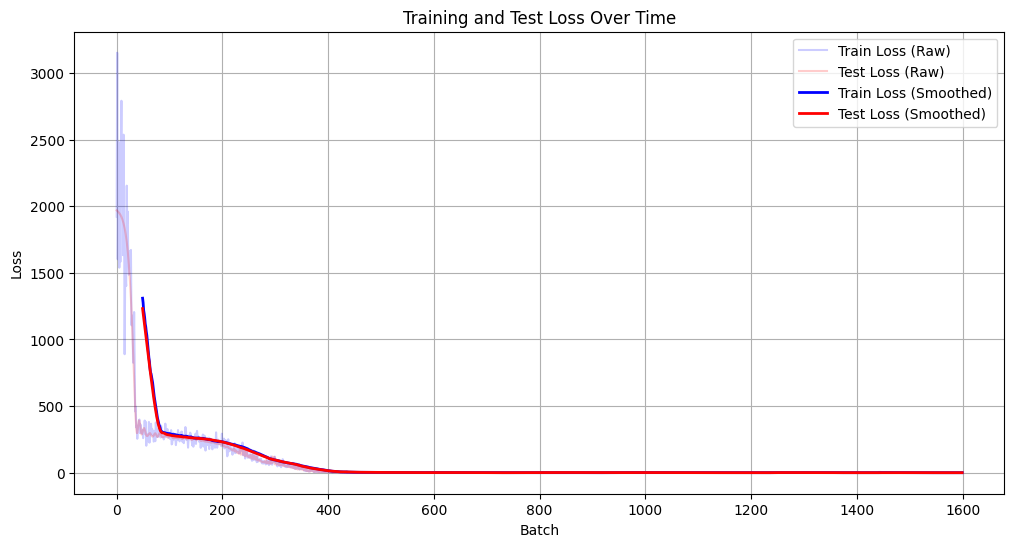

In [25]:
plot_losses(train_losses, test_losses, window_size=50)  # Adjust window_size as needed

## Prediction on test set

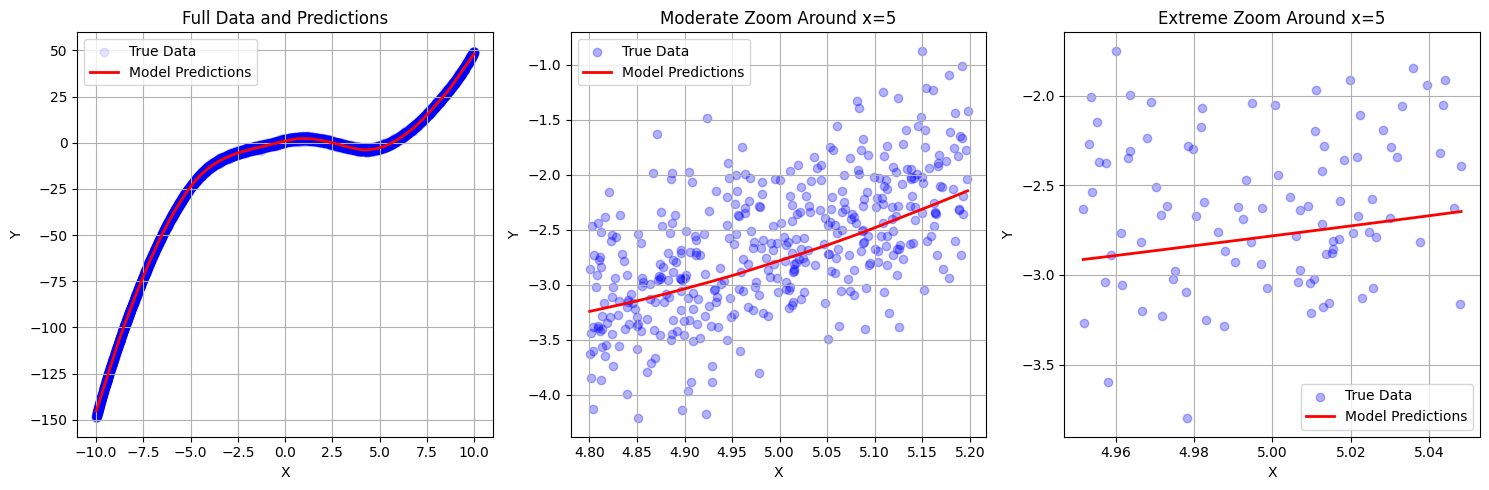

In [31]:
# Evaluate model and get predictions
model.eval()
with torch.no_grad():
    X_test_sorted, indices = torch.sort(torch.FloatTensor(X_test), dim=0)
    y_test_sorted = torch.FloatTensor(y_test)[indices]
    predictions = model(X_test_sorted)

# Create figure with three subplots
plt.figure(figsize=(15, 5))

# Plot 1: Full curve
plt.subplot(1, 3, 1)
plt.scatter(X_test_sorted.numpy(), y_test_sorted.numpy(), alpha=0.1, label='True Data', color='blue')
plt.plot(X_test_sorted.numpy(), predictions.numpy(), color='red', label='Model Predictions', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Full Data and Predictions')
plt.legend()
plt.grid(True)

# Plot 2: First zoom level (moderate zoom)
plt.subplot(1, 3, 2)
zoom_center1 = 5
zoom_range1 = 0.2  # Reduced from 0.5 to 0.2
mask1 = (X_test_sorted.numpy() >= zoom_center1 - zoom_range1) & (X_test_sorted.numpy() <= zoom_center1 + zoom_range1)
plt.scatter(X_test_sorted.numpy()[mask1], y_test_sorted.numpy()[mask1], alpha=0.3, label='True Data', color='blue')
plt.plot(X_test_sorted.numpy()[mask1], predictions.numpy()[mask1], color='red', label='Model Predictions', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Moderate Zoom Around x={zoom_center1}')
plt.legend()
plt.grid(True)

# Plot 3: Extreme zoom
plt.subplot(1, 3, 3)
zoom_center2 = 5
zoom_range2 = 0.05  # Very narrow range of just 0.1 units
mask2 = (X_test_sorted.numpy() >= zoom_center2 - zoom_range2) & (X_test_sorted.numpy() <= zoom_center2 + zoom_range2)
plt.scatter(X_test_sorted.numpy()[mask2], y_test_sorted.numpy()[mask2], alpha=0.3, label='True Data', color='blue')
plt.plot(X_test_sorted.numpy()[mask2], predictions.numpy()[mask2], color='red', label='Model Predictions', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Extreme Zoom Around x={zoom_center2}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### TLDR: You should expect wiggle/overfitting, the model does smooth interpolation

## Prediction on train set

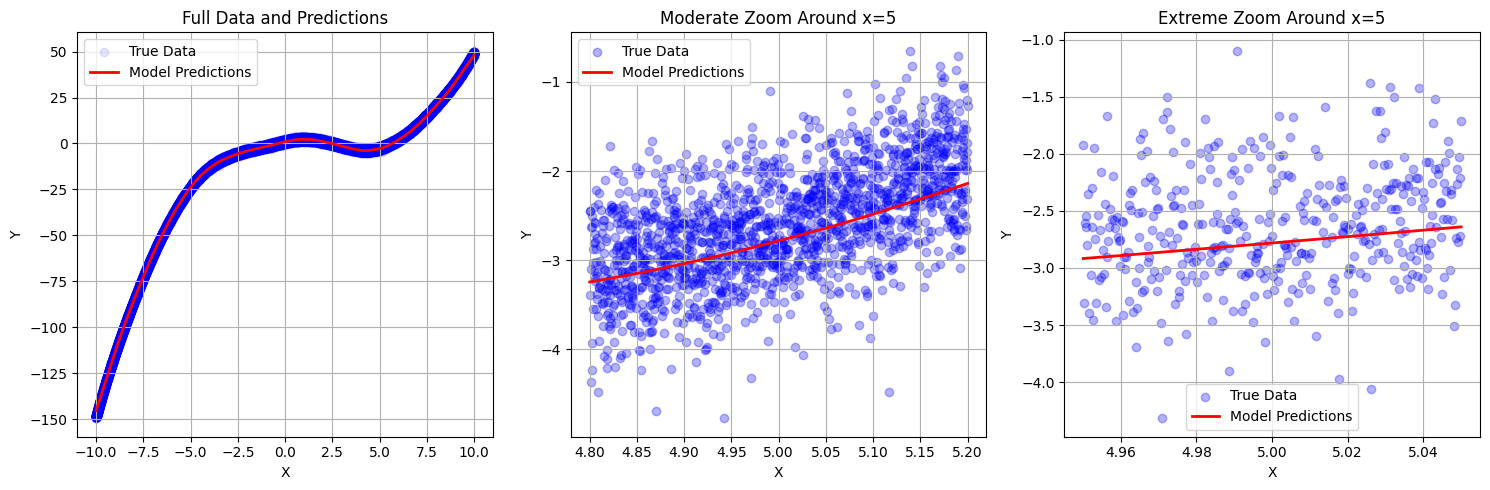

In [35]:
# Evaluate model and get predictions
model.eval()
with torch.no_grad():
    X_train_sorted, indices = torch.sort(torch.FloatTensor(X_train), dim=0)
    y_train_sorted = torch.FloatTensor(y_train)[indices]
    predictions = model(X_train_sorted)

# Create figure with three subplots
plt.figure(figsize=(15, 5))

# Plot 1: Full curve
plt.subplot(1, 3, 1)
plt.scatter(X_train_sorted.numpy(), y_train_sorted.numpy(), alpha=0.1, label='True Data', color='blue')
plt.plot(X_train_sorted.numpy(), predictions.numpy(), color='red', label='Model Predictions', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Full Data and Predictions')
plt.legend()
plt.grid(True)

# Plot 2: First zoom level (moderate zoom)
plt.subplot(1, 3, 2)
zoom_center1 = 5
zoom_range1 = 0.2  # Reduced from 0.5 to 0.2
mask1 = (X_train_sorted.numpy() >= zoom_center1 - zoom_range1) & (X_train_sorted.numpy() <= zoom_center1 + zoom_range1)
plt.scatter(X_train_sorted.numpy()[mask1], y_train_sorted.numpy()[mask1], alpha=0.3, label='True Data', color='blue')
plt.plot(X_train_sorted.numpy()[mask1], predictions.numpy()[mask1], color='red', label='Model Predictions', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Moderate Zoom Around x={zoom_center1}')
plt.legend()
plt.grid(True)

# Plot 3: Extreme zoom
plt.subplot(1, 3, 3)
zoom_center2 = 5
zoom_range2 = 0.05  # Very narrow range of just 0.1 units
mask2 = (X_train_sorted.numpy() >= zoom_center2 - zoom_range2) & (X_train_sorted.numpy() <= zoom_center2 + zoom_range2)
plt.scatter(X_train_sorted.numpy()[mask2], y_train_sorted.numpy()[mask2], alpha=0.3, label='True Data', color='blue')
plt.plot(X_train_sorted.numpy()[mask2], predictions.numpy()[mask2], color='red', label='Model Predictions', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Extreme Zoom Around x={zoom_center2}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## You can see even in train dataset, there's no overfitting